This notebook compare a token of actual market and argumented data before creating Dataset with a data argument

In [2]:
import os
import time

try:
  from google.colab import drive
  IS_GOOGLE_COLAB = True
except ImportError:
  IS_GOOGLE_COLAB = False

if IS_GOOGLE_COLAB:
  mount_path='/content/drive'
  base_folder = "/Data/FX"
  data_folder = f'{mount_path}/My Drive{base_folder}'
  drive.mount(mount_path)
else:
  base_folder = '../../Data/'
  data_folder = os.path.join(base_folder, "fx")

# Deterministic Multi Agent Simulation

In [3]:
import random
from collections.abc import Iterable

import numpy as np
import pandas as pd


class DeterministicDealerModelV1:
    
    def __init__(self, num_agent, max_volatility = 0.02, min_volatility = 0.01, trade_unit=0.001, initial_price=100, spread=1, initial_positions=None, tick_time=0.001, experimental=False) -> None:
        # min_vol should be greater than 0
        # agent tendency: agent change his order prices based on the tendency
        tendency = pd.Series([random.uniform(min_volatility, max_volatility) for i in range(num_agent)], dtype=float)
        if trade_unit < 1:
            do_round = True
            decimal = 0.1
            decimal_num = 1
            while True:
                check = trade_unit / decimal
                if check >= 1 - trade_unit:
                    break
                decimal *= 0.1
                decimal_num += 1
                if decimal_num > 100:
                    do_round = False 
                    break
            if do_round is True:
                tendency = tendency.round(decimal_num)
        prices = pd.Series([random.uniform(initial_price, initial_price + spread) for i in range(num_agent)], dtype=float)
        if initial_positions is None:
            position_trends = pd.Series([random.choice([-1, 1]) for i in range(num_agent)], dtype=int)
        elif len(initial_positions) == num_agent:
            position_trends = pd.Series(initial_positions, dtype=int)
        else:
            raise ValueError("initial position is invalid.")
        self.agent_df = pd.concat([tendency, position_trends, prices], axis=1, keys=["tend", "position", "price"], names=["id"])
        self.spread = spread
        self.market_price = initial_price + self.spread
        self.__initial_price = initial_price
        self.__min_vol = min_volatility
        self.__max_vol = max_volatility
        self.trade_unit = trade_unit
        self.tick_time = 0.0
        self.tick_time_unit = tick_time
        if experimental is True:
            self.simulate = self.__freq_advance_simulate
        else:
            self.simulate = self.__ref_simulate
                
    def advance_order_price(self):
        self.agent_df.price += self.agent_df.position * self.agent_df.tend
        # print("*kept*")
        # print(self.agent_df)
        return self.agent_df.price
    
    def contruct(self):
        ask_agents = self.agent_df.loc[self.agent_df.position == 1]
        bought_agent_id = ask_agents.price.idxmax()
        ask_order_price = ask_agents.price[bought_agent_id]
        
        bid_agents = self.agent_df.loc[self.agent_df.position == -1]
        sold_agent_id = bid_agents.price.idxmin()
        bid_order_price = bid_agents.price[sold_agent_id] + self.spread
    
        if ask_order_price >= bid_order_price:
            # print("---contructed!!---")
            self.market_price = (((ask_order_price + bid_order_price)/2) // self.trade_unit) * self.trade_unit
            # print(bought_agent_id, sold_agent_id)
            self.agent_df.loc[bought_agent_id, "position"] = -1
            self.agent_df.loc[sold_agent_id, "position"] = 1
            # print(self.agent_df)
            return self.market_price
        return None
            
    
    def __ref_simulate(self, ticks_num:int):
        price_history = [self.market_price]
        tick_times = [self.tick_time]
        for tick in range(ticks_num):
            self.tick_time += self.tick_time_unit
            price = self.contruct()
            if price is not None:
                # print(self.tick_time)
                price_history.append(price)
                tick_times.append(self.tick_time)
            else:
                self.advance_order_price()
        price_hist_df = pd.DataFrame(price_history, columns=["price"])
        return price_hist_df, tick_times
    
    def __freq_advance_simulate(self, ticks_num:int):
        price_history = [self.market_price]
        tick_times = [self.tick_time]
        for tick in range(ticks_num):
            self.tick_time += self.tick_time_unit
            self.advance_order_price()
            price = self.contruct()
            if price is not None:
                # print(self.tick_time)
                price_history.append(price)
                tick_times.append(self.tick_time)
        price_hist_df = pd.DataFrame(price_history, columns=["price"])
        return price_hist_df, tick_times

class DeterministicDealerModelV3(DeterministicDealerModelV1):
    
    def __init__(self, num_agent, max_volatility = 0.02, min_volatility = 0.01, trade_unit=0.001, initial_price=100, spread=1, initial_positions=None, tick_time=0.001,
                 dealer_sensitive=None, wma=1, dealer_sensitive_min=-3.5, dealer_sensitive_max=-1.5
                 ) -> None:
        """_summary_

        Args:
            dealer_sensitive (int|Iterable, optional): this values represent sensitivity of each agent for past prices. greater/less than 0 means follower/contrarian. Defaults to None and initialized with random values by normal dist with mean and sigma
            wma (int|Iterable, optional): this values represent how long agents will be affected by past values. Defaults to 1.
        """
        super().__init__(num_agent, max_volatility, min_volatility, trade_unit, initial_price, spread, initial_positions, tick_time)
        self.price_history = [self.market_price]
        self.tick_times = [self.tick_time]
        
        if dealer_sensitive is None:
            # create array with random values between -1 to 1 
            self.dealer_sensitive = np.asarray([random.uniform(dealer_sensitive_min, dealer_sensitive_max) for i in range(num_agent)])
        elif isinstance(dealer_sensitive, (int, float)):
            # create array with fixed value
            self.dealer_sensitive = np.asarray([ dealer_sensitive for i in range(num_agent)])
        elif isinstance(dealer_sensitive, Iterable):
            # use provided array
            self.dealer_sensitive = np.asanyarray(dealer_sensitive)
        else:
            raise TypeError("dealer_sensitive must be either float or Iterable object")
        
        if isinstance(wma, int):
            # create weight array with random values between 0 to 1 
            self.weight_array = np.asarray([random.uniform(0, 1) for i in range(wma)])
            self.__total_weight = np.sum(self.weight_array)
            self.wma = wma
        elif isinstance(wma, Iterable):
            #  use wma as weight array
            self.weight_array = np.asarray(wma)
            self.__total_weight = np.sum(self.weight_array)
            self.wma = len(wma)
        else:
            raise TypeError("wma must be either int or Iterable object")
            
    
    def __wma(self):
        if len(self.price_history) >= self.wma + 1:
            wma_price = 0.0
            for i in range(1, self.wma+1):
                price_diff = self.price_history[-i] - self.price_history[-i -1]
                wma_price += (self.weight_array[i-1] * price_diff)
            return wma_price/self.__total_weight
        else:
            return 0
                
    def advance_order_price(self):
        follow_factors = self.dealer_sensitive * self.__wma()
        self.agent_df.price += self.agent_df.position * self.agent_df.tend + follow_factors
        return self.agent_df.price
            
    
    def simulate(self, ticks_num:int):
        for tick in range(ticks_num):
            self.tick_time += self.tick_time_unit
            price = self.contruct()
            if price is not None:
                # print(self.tick_time)
                self.price_history.append(price)
                self.tick_times.append(self.tick_time)
            else:
                self.advance_order_price()
        price_hist_df = pd.DataFrame(self.price_history, columns=["price"])
        return price_hist_df, np.asarray(self.tick_times)

## Investigation

In [ ]:
import matplotlib.pyplot as plt

# Loaad Actual Market Data
tick_df = pd.read_csv(f"{data_folder}/OANDA_2021_tick.csv", index_col=0, parse_dates=True)
# remove market holiday
out_condition = 3600 * 24
time_diff = (tick_df.index[1:] - tick_df.index[:-1]).total_seconds()
time_diff = time_diff[time_diff < out_condition]
min_span = time_diff[time_diff > 0].min()
time_span = np.round(time_diff/min_span)
mean_spread = tick_df.spread.mean()

In [68]:
start_time = time.time()
model = DeterministicDealerModelV3(1000, spread=mean_spread*100)
prices, ticks = model.simulate(len(tick_df))
end_time = time.time()
elasped_time = end_time - start_time

In [35]:
def cumulative_dist(data, bins=100):
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts_prob = counts/counts.sum()
    cumulative = np.cumsum(counts_prob)
    possibilities = 1 - cumulative
    return np.array([1, *possibilities]) , np.array([1e-10, *bin_edges[1:]])

### Tick Data Comparison

In [38]:
token_length = 60
tick_src = tick_df.price.diff().iloc[1:]
tick_token_sample = tick_src.iloc[:token_length]
tick_token_sample.head()

2020-12-31 17:00:00.166    0.000
2020-12-31 17:00:00.204    0.000
2020-12-31 17:00:00.231    0.000
2020-12-31 17:00:02.442    0.001
2020-12-31 17:00:02.485    0.000
Name: price, dtype: float64

In [62]:
sim_src = prices.price.diff().iloc[1:]
sim_src.head()

1   -0.002633
2    0.000000
3    0.000000
4    0.000000
5    0.000000
Name: price, dtype: float64

In [32]:
tick_src.describe()

count    7.315639e+07
mean     1.645516e-07
std      7.874238e-04
min     -2.510000e-01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.600000e-01
Name: price, dtype: float64

In [63]:
# outlier is not simulated in the model. So min/max value is greater/less than market result.
sim_src.describe()

count    9474.000000
mean       -0.000027
std         0.000855
min        -0.006000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.006000
Name: price, dtype: float64

In [31]:
print('skew:', tick_src.skew())
print('kurt:', tick_src.kurtosis())

skew: -0.6811019188661253
kurt: 1899.1727622185908


In [64]:
print('skew:', sim_src.skew())
print('kurt:', sim_src.kurtosis())

skew: 0.01017510498256384
kurt: 2.9946326347086965


In [39]:
mean = tick_src.mean()
std = tick_src.std()

cumulative, bin_edges = cumulative_dist(tick_src.abs(), bins=500)
num_samples = 1000
data = abs(np.random.normal(mean, std, num_samples))
n_cumulative, n_bin_edges = cumulative_dist(data)

In [66]:
mean = sim_src.mean()
std = sim_src.std()

sim_cumulative, sim_bin_edges = cumulative_dist(sim_src.abs(), bins=500)
num_samples = 1000
data = abs(np.random.normal(mean, std, num_samples))
sim_n_cumulative, sim_n_bin_edges = cumulative_dist(data)

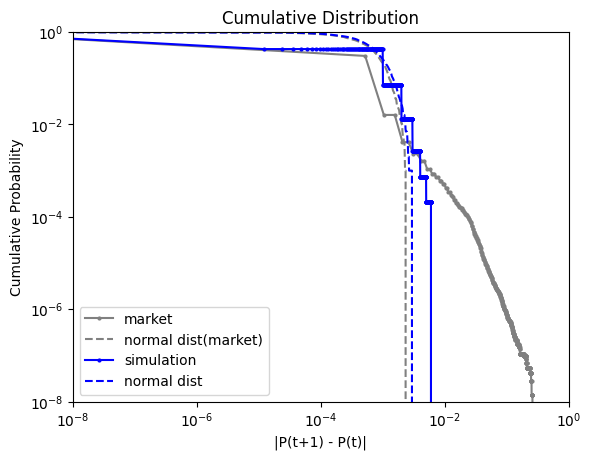

In [67]:
plt.plot(bin_edges, cumulative, color="gray", marker="o", markersize=2, label="market")
plt.plot(n_bin_edges, n_cumulative, color="gray", linestyle="--", label="normal dist(market)")

plt.plot(sim_bin_edges, sim_cumulative, color="blue", marker="o", markersize=2, label="simulation")
plt.plot(sim_n_bin_edges, sim_n_cumulative, color="blue", linestyle="--", label="normal dist")

plt.title('Cumulative Distribution')
plt.xlabel('|P(t+1) - P(t)|')
plt.ylabel('Cumulative Probability')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8, 1)
plt.xlim(1e-8, 1)
plt.legend()
plt.show()

In [ ]:
ohlc_column = ['open','high','low','close']
ohlc_token_features = ohlc_column
df = pd.read_csv(f"{data_folder}/mt5_USDJPY_min30.zip", parse_dates=True, index_col=0)

In [29]:
ohlc_src = df[ohlc_token_features].diff()
ohlc_token_sample = ohlc_src.iloc[1:token_length]
ohlc_token_sample.head()

,open,high,low,close
time,,,,
2014-07-07 09:00:00,0.016,0.024,0.017,0.011
2014-07-07 09:30:00,0.011,-0.031,-0.056,-0.069
2014-07-07 10:00:00,-0.066,-0.063,-0.037,-0.025
2014-07-07 10:30:00,-0.030,-0.027,-0.087,-0.078
2014-07-07 11:00:00,-0.076,-0.074,0.001,0.008
